In [12]:
# -*- coding: utf-8 -*-
from __future__ import print_function
"""
Created on Tue Oct 23 14:03:51 2018

@author: xingshuli

"""

from keras import applications
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
#from keras_flops import get_flops
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers.convolutional import DepthwiseConv2D
#from keras_applications import DepthwiseConv2D
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras import backend as K
import keras.layers  as KL
import numpy as np

def channel_split(x, name = ''):
    in_channels = x.shape.as_list()[-1]
    ip = in_channels // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip])(x)
    c = Lambda(lambda z: z[:, :, :, ip:])(x)
    
    return c_hat, c


def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    
    return x

def _shuffle_unit(inputs, out_channels, strides = 2, stage = 1, block = 1):
    
    bn_axis = -1
    prefix = 'stage%d/block%d' %(stage, block)
    
    branch_channels = out_channels // 2
    
    if strides == 2:
        x_1 = DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same', 
                              use_bias = False, name = '%s/3x3dwconv_1' % prefix)(inputs)
        x_1 = BatchNormalization(axis = bn_axis, name = '%s/bn_3x3dwconv_1' % prefix)(x_1)
        x_1 = Conv2D(filters = branch_channels, kernel_size = 1, strides = 1, padding = 'same', 
                     use_bias = False, name = '%s/1x1conv_1' % prefix)(x_1)
        x_1 = BatchNormalization(axis = bn_axis, name = '%s/bn_1x1conv_1' % prefix)(x_1)
        x_1 = Activation('relu')(x_1)
        
        x_2 = Conv2D(filters = branch_channels, kernel_size = 1, strides = 1, padding = 'same', 
                     use_bias = False, name = '%s/1x1conv_2' % prefix)(inputs)
        x_2 = BatchNormalization(axis = bn_axis, name = '%s/bn_1x1conv_2' % prefix)(x_2)
        x_2 = Activation('relu')(x_2)
        x_2 = DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same', 
                              use_bias = False, name = '%s/3x3dwconv_2' % prefix)(x_2)
        x_2 = BatchNormalization(axis = bn_axis, name = '%s/bn_3x3dwconv_2' % prefix)(x_2)
        x_2 = Conv2D(filters = branch_channels, kernel_size = 1, strides = 1, padding = 'same', 
                     use_bias = False, name = '%s/1x1conv_3' % prefix)(x_2)
        x_2 = BatchNormalization(axis = bn_axis, name = '%s/bn_1x1conv_3' % prefix)(x_2)
        x_2 = Activation('relu')(x_2)
        
        #x_1 = SGE(groups=16)(x_1)
        #x_2 = SGE(groups=16)(x_2)
        
        x = Concatenate(axis = bn_axis, name = '%s/concat' % prefix)([x_1, x_2])
        
    if strides == 1:
        c_hat, c = channel_split(inputs, name = '%s/split' % prefix)
        
        c = Conv2D(filters = branch_channels, kernel_size = 1, strides = 1, padding = 'same', 
                   use_bias = False, name = '%s/1x1conv_4' % prefix)(c)
        c = BatchNormalization(axis = bn_axis, name = '%s/bn_1x1conv_4' % prefix)(c)
        c = Activation('relu')(c)
        c = DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same', 
                            use_bias = False, name = '%s/3x3dwconv_3' % prefix)(c)
        c = BatchNormalization(axis = bn_axis, name = '%s/bn_3x3dwconv_3' % prefix)(c)
        c = Conv2D(filters = branch_channels, kernel_size = 1, strides = 1, padding = 'same', 
                   use_bias = False, name = '%s/1x1conv_5' % prefix)(c)
        c = BatchNormalization(axis = bn_axis, name = '%s/bn_1x1conv_5' % prefix)(c)
        c = Activation('relu')(c)
        
        
        x = Concatenate(axis = bn_axis, name = '%s/concat' % prefix)([c_hat, c])
        
    x = Lambda(channel_shuffle, name = '%s/channel_shuffle' % prefix)(x)
    
    return x

def v2_block(x, channel_map, repeat = 1, stage = 1):
    x = _shuffle_unit(x, out_channels = channel_map[stage - 1], strides = 2, 
                      stage = stage, block = 1)
    
    for i in range(1, repeat + 1):
        x = _shuffle_unit(x, out_channels = channel_map[stage - 1], strides = 1, 
                          stage = stage, block = (i + 1))
    
    return x


def ShuffleNet_V2(include_top = True, input_tensor = None, scale_factor = 1.0, pooling = 'avg', 
                  input_shape = (256, 256, 3), num_shuffle_units = [1, 2, 1], weights = None, 
                  classes = 6):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported')
    
    input_shape = _obtain_input_shape(input_shape, 
                                      default_size = 256, 
                                      min_size = 28, 
                                      data_format = K.image_data_format(), 
                                      require_flatten = include_top, 
                                      weights = weights)
    
    out_dim_stage_two = {0.5: 48, 1: 116, 1.5: 176, 2: 244}
    
    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    
    if not (float(scale_factor) * 4).is_integer():
        raise ValueError('Invalid value for scale_factor. Should be x over 4')
    
    exp = np.insert(np.arange(len(num_shuffle_units), dtype = np.float32), 0, 0)
    out_channels_in_stage = 2 ** exp
    out_channels_in_stage *= out_dim_stage_two[scale_factor]
    out_channels_in_stage[0] = 24
    out_channels_in_stage = out_channels_in_stage.astype(int)
    
    if input_tensor is None:
        img_input = Input(shape = input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(shape = input_shape, tensor = input_tensor)
        else:
            img_input = input_tensor
            
    
    x = Conv2D(filters = out_channels_in_stage[0], kernel_size = 3, strides = 2, 
               padding = 'same', use_bias = False, activation = 'relu', name = 'conv1')(img_input)
    #y = se_block(x)
    #y = SGE(groups=x)
    #x = KL.add([x,y])
    x = MaxPooling2D(pool_size = 3, strides = 2, padding = 'same', name = 'MaxPool1')(x)
    #y = SGE(groups=groups)(img_input)
    #x = KL.add([x,y])
    
    #construct stage2 to 4
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = v2_block(x, channel_map = out_channels_in_stage, repeat = repeat, stage = stage + 2)
        
        
    #construct final layers
    if scale_factor == 2:
        x = Conv2D(filters = 2048, kernel_size = 1, strides = 1, padding = 'same', 
                   use_bias = False, activation = 'relu', name = 'conv5')(x)
    else:
        x = Conv2D(filters = 1024, kernel_size = 1, strides = 1, padding = 'same', 
                   use_bias = False, activation = 'relu', name = 'conv5')(x)
    
    if pooling == 'avg':
        x = GlobalAveragePooling2D(name = 'global_average_pool')(x)
        #x = SGE(groups=16)(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name = 'global_max_pool')(x)
        
        #y = SGE(groups=16)(x)
        #x = KL.add([x,y])
    
    if include_top:
        x = Dense(classes, name = 'fc')(x)
        x = Activation('softmax')(x)
       
        
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:  
        inputs = img_input
    
    #construct model function
    model = Model(inputs = inputs, outputs = x, name = 'ShuffleNet_V2')
    
    return model



if __name__ == '__main__':
    
    
    model = ShuffleNet_V2(input_shape=[256,256,3],  # 输入图像的shape
                       classes = 6) # 图像分类类别
   
    model.summary()  # 查看网络结构
 


    model_layers = [ layer.name for layer in model.layers]
    print('layer name : ',model_layers)

    #keras.utils.plot_model(model,"my_CNN_model1230.png")

#print('flops:', get_flops(model, batch_size=1)) 








Model: "ShuffleNet_V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
MaxPool1 (MaxPooling2D)         (None, 64, 64, 24)   0           conv1[0][0]                      
__________________________________________________________________________________________________
stage2/block1/1x1conv_2 (Conv2D (None, 64, 64, 58)   1392        MaxPool1[0][0]                   
_______________________________________________________________________________

In [13]:
import tensorflow as tf
import time
from keras import optimizers
opt = optimizers.SGD(lr=1e-2, momentum=0.9,decay=0.0008)
#opt = Adam(lr=INIT_LR,decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])  #CrossEntropyLoss  'categorical_crossentropy'
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)

In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=60, verbose=1
    
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/60
1123/1123 [==============================] - 133s 118ms/step - loss: 1.1750 - acc: 0.5492 - val_loss: 0.8036 - val_acc: 0.7040
Epoch 2/60
1123/1123 [==============================] - 92s 82ms/step - loss: 0.7258 - acc: 0.7359 - val_loss: 2.2726 - val_acc: 0.5516
Epoch 3/60
1123/1123 [==============================] - 91s 81ms/step - loss: 0.5151 - acc: 0.8129 - val_loss: 0.6333 - val_acc: 0.7811
Epoch 4/60
1123/1123 [==============================] - 91s 81ms/step - loss: 0.3950 - acc: 0.8586 - val_loss: 0.4730 - val_acc: 0.8278
Epoch 5/60
1123/1123 [==============================] - 91s 81ms/step - loss: 0.3252 - acc: 0.8869 - val_loss: 0.8666 - val_acc: 0.7481
Epoch 6/60
1123/1123 [==============================] - 91s 81ms/step - loss: 0.2672 - acc: 0.9065 - val_loss: 0.2022 - val_acc: 0.9353
Epoch 7/60
1123/1123 [==============================] - 91s 81ms/step - loss: 0.2138 - a

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

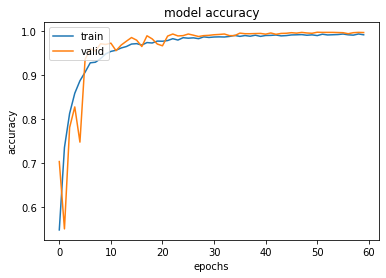

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

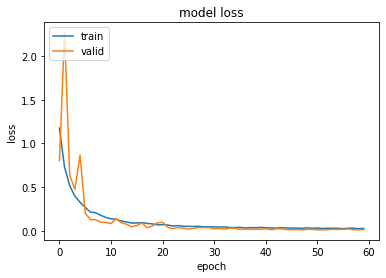

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score

Y_preds = model.predict(x_test)

Y_preds = np.argmax(Y_preds, axis=1)
Y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(np.round(Y_preds),Y_true)*100
cm = confusion_matrix(Y_true, np.round(Y_preds))
precision=precision_score(np.round(Y_preds),Y_true,average='weighted')*100
recall=recall_score(np.round(Y_preds),Y_true,average='weighted')*100
#tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
#precision = tp/(tp+fp)*100
#recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[509   0   0   0   0   0]
 [  0 701   1   0   1   0]
 [  2   0 608   0   0   0]
 [  0   1   0 386   0   0]
 [  1   3   0   0 288   2]
 [  0   0   0   0   0 494]]

============TEST METRICS=============
Accuracy: 99.63296629963297%
Precision: 99.63637682962138%
Recall: 99.63296629963297%
F1-score: 99.63467153544126

TRAIN METRIC ----------------------
Train acc: 99.12


In [19]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = [ 'Commom rust','Bipolaris maydis','Curvularia lunata(wakker) boed spot','Northern leaf blight','Own spot','Sheath blight']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

                                     precision    recall  f1-score   support

                        Commom rust       0.99      1.00      1.00       509
                   Bipolaris maydis       0.99      1.00      1.00       703
Curvularia lunata(wakker) boed spot       1.00      1.00      1.00       610
               Northern leaf blight       1.00      1.00      1.00       387
                           Own spot       1.00      0.98      0.99       294
                      Sheath blight       1.00      1.00      1.00       494

                           accuracy                           1.00      2997
                          macro avg       1.00      1.00      1.00      2997
                       weighted avg       1.00      1.00      1.00      2997



In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
2997/2997 [==============================] - 5s 2ms/step
Test Accuracy: 99.63296629963297


In [21]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

2997/2997 [==============================] - 5s 2ms/step
0.013222430555882044
0.9963296629963296


In [22]:
print(history.history['val_acc'])

[0.7040373707438136, 0.5515515515714396, 0.7811144478010026, 0.8278278278278278, 0.7480814147480814, 0.9352686019352686, 0.9592926259592927, 0.9542876209542877, 0.970970970970971, 0.9693026359693027, 0.9723056389723056, 0.9552886219552886, 0.9679679679679679, 0.9766433099766433, 0.984984984984985, 0.978978978978979, 0.9646312979646313, 0.988988988988989, 0.9819819819819819, 0.9703036369703036, 0.9662996329662996, 0.9883216549883217, 0.992992992992993, 0.9886553219886554, 0.9893226559893227, 0.992992992992993, 0.9903236569903237, 0.9873206539873206, 0.9893226559893227, 0.98998998998999, 0.9913246579913246, 0.991991991991992, 0.992992992992993, 0.9893226559893227, 0.9893226559893227, 0.994994994994995, 0.9936603269936604, 0.9936603269936604, 0.993993993993994, 0.9943276609943277, 0.9926593259926594, 0.9953286619953287, 0.9923256589923256, 0.9943276609943277, 0.9946613279946613, 0.995995995995996, 0.994994994994995, 0.9966633299966633, 0.9953286619953287, 0.9946613279946613, 0.99699699699

In [23]:
print(history.history['val_loss'])

[0.8036213992713569, 2.27260680097439, 0.633285835091973, 0.47300028092637136, 0.8665685190716345, 0.2021617884811388, 0.12702058424472729, 0.12585015079515563, 0.09728405783103619, 0.09406251379331927, 0.08221089776565281, 0.13838331311805038, 0.09212741776776052, 0.07440988387363102, 0.044550776214760765, 0.05943764095544195, 0.0893706988525229, 0.03310707147477672, 0.05430582308563796, 0.09115035479840852, 0.09668201996406002, 0.038481595036262424, 0.02434490404828179, 0.037919786068269644, 0.028331399637967887, 0.019846227572629015, 0.02574821437048026, 0.037149366692370775, 0.035167203901022924, 0.03715000324774775, 0.02185491898789462, 0.02570887958889193, 0.017779449427686993, 0.031493675991358556, 0.026244779959952565, 0.016401038792925732, 0.01785861462220153, 0.015403725339204226, 0.01746475801058805, 0.017739607901028073, 0.023597269470756323, 0.011852883119758958, 0.021737736099244388, 0.021939526591666533, 0.013938388228777207, 0.011399285201549087, 0.012076273615723668, 0

In [24]:
print(history.history['acc'])

[0.54920953017809, 0.7359162769851693, 0.8129592518502794, 0.8587174348697395, 0.8869962146647973, 0.9064796259185037, 0.9277443776441773, 0.9290803829749266, 0.9372077488177233, 0.9480071253618347, 0.9535738142952572, 0.956245824996572, 0.9613671788020486, 0.9645958583834335, 0.9702738810955244, 0.971164551324872, 0.9679358717434869, 0.9736138944555778, 0.9726118904475618, 0.9769539078156313, 0.9766199064796259, 0.9781785793809842, 0.9824092629703852, 0.9792919171543967, 0.9846359385437542, 0.9835226007570697, 0.9843019371944768, 0.9824092629703852, 0.9865286127811178, 0.9851926074370965, 0.9861946114451124, 0.9865286127811178, 0.9861946114451124, 0.9875306167891338, 0.9898686261411712, 0.9876419505678022, 0.9895346248051659, 0.9879759519038076, 0.990313961255845, 0.9876419505678022, 0.9896459585838343, 0.9898686261278992, 0.9907592963705188, 0.9887552883412147, 0.9894232910132255, 0.9908706301491873, 0.9912046314719206, 0.9916499665998664, 0.9902026274771766, 0.9910932977065242, 0.98

In [25]:
print(history.history['loss'])

[1.1750188313940537, 0.7257357319919391, 0.5150082587094224, 0.3948306202875217, 0.3251847980170281, 0.26718932406885987, 0.2136190683730038, 0.2062382146780819, 0.17750558743564, 0.1518600541128597, 0.1359940312567006, 0.13072939948544846, 0.11107462121332796, 0.10069538391826903, 0.08807570516477409, 0.08866928947238309, 0.09345293457197215, 0.08403989491137431, 0.07832802448710383, 0.06720555303205376, 0.06941726293371904, 0.0652883694894792, 0.054144612446552186, 0.05935914543039934, 0.051324950655990936, 0.05024423049831927, 0.04897020228083438, 0.05145809810730173, 0.043993219453197285, 0.04588819909072756, 0.04426236271098081, 0.043152455633153224, 0.04287564703410838, 0.03790746538627426, 0.03545633467074675, 0.0389293979367252, 0.03296268348845728, 0.03605476364447903, 0.03464783414941906, 0.03820064021005378, 0.03319093999277009, 0.03235031527790214, 0.03083291347629804, 0.03434819304343205, 0.03208564498769515, 0.030159306094479855, 0.0309108168567437, 0.027115133456250908, 

In [26]:
pred = model.predict(x_test,verbose=1)
y_pred = np.argmax(pred, axis = 1)
y_pred

2997/2997 [==============================] - 5s 2ms/step


array([0, 5, 1, ..., 0, 0, 1], dtype=int64)

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[509   0   0   0   0   0]
 [  0 701   1   0   1   0]
 [  2   0 608   0   0   0]
 [  0   1   0 386   0   0]
 [  1   3   0   0 288   2]
 [  0   0   0   0   0 494]]


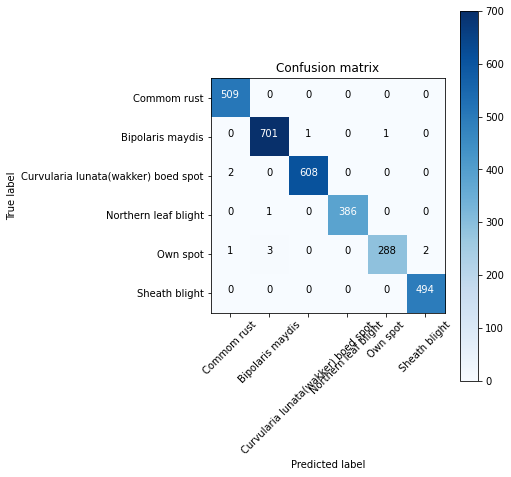

In [28]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')

In [29]:
import tensorflow as tf
import tensorflow.keras.backend as K

def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)
 
    return flops.total_float_ops

if __name__ == "__main__":
    x = K.random_normal(shape=(1, 1, 100, 256))
    model = ShuffleNet_V2(x.shape)
    print('FLOPs of tensorflow 1.12.0:', get_flops(model))


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPs of tensorflow 1.12.0: 7110113
